# 6.03: Handling Outliers in Feature Engineering

## What are Outliers?
- **Outliers** are data points that deviate significantly from the rest of the dataset.  
- They can appear in:
  - **Features (independent variables)**
  - **Target (dependent variable)**  

**Example:**  
- Most house prices are between $100k – $500k, but one property costs $5M -> **outlier**.  
- A sensor suddenly records 999°C -> **outlier**.

## Why Do Outliers Matter?
1. **Distort Statistics**
   - Mean, standard deviation, and correlation are sensitive to extreme values.  

2. **Impact Models**

   Outliers have a Negative impact on a certain set of ML Algorithms:
   - Linear Regression -> regression line pulled by outliers  
   - KNN → distance gets skewed  
   - K-Means → centroids shift
   - Deep Learning
     
     
   Algorithms which are not much affected by Ouliers:
   - Tree Based
   - Naive Bayes
     

3. **Affect Feature Scaling**
   - StandardScaler & MinMaxScaler is influenced by outliers.  
    <div align="center">
      <img src="feature_scaling.png" alt="Sample Image" width="400"/>
    </div>

4. **Sometimes Outliers are Valuable**
   - Fraud detection -> unusual transactions are important.  
   - Anomaly detection -> relies on outliers.

## Sources of Outliers
- **Measurement errors** (wrong sensor reading, typos)  
- **Natural variation** (rare but valid cases)  
- **Sampling issues** (mix of different populations)  
- **Rare events** (fraud, medical anomalies, system failures)

## Handling Outliers in Feature Engineering

### 1. Detection

#### Visualization: boxplot, scatterplot, histogram
Discussed in the last lecture 6.02

#### Z-score

<div align="center">
      <img src="https://media.geeksforgeeks.org/wp-content/uploads/20250606125317822107/a_normal_distribution1.webp" alt="Sample Image" width="600"/>
    </div>

* The Z-score tells us how far a data point is from the mean in terms of standard deviations.
* The **Z-score** of a data point $x_i$ is given by:

$$
z_i = \frac{x_i - \mu}{\sigma}
$$

Where:
- $x_i$ = data point  
- $\mu$ = mean of the distribution  
- $\sigma$ = standard deviation of the distribution

* Rule of Thumb - If ∣Z∣>3, the point is usually considered an outlier.

In [37]:
# Sample data
data = [10, 12, 12, 13, 13, 14,  12, 14, 13, 19, 90]  # 90 looks suspicious
df_sample = pd.DataFrame(data, columns=['value'])

In [38]:
# Calculate Z-score
df_sample['z_score'] = (df_sample['value'] - df_sample['value'].mean()) / df_sample['value'].std()

# Detect outliers
outliers_z = df_sample[df_sample['z_score'].abs() > 3]
print(outliers_z)
print(20*"-")
df_sample

    value   z_score
10     90  3.001264
--------------------


,value,z_score
0,10,-0.437684
1,12,-0.351711
2,12,-0.351711
3,13,-0.308724
4,13,-0.308724
5,14,-0.265737
6,12,-0.351711
7,14,-0.265737
8,13,-0.308724
9,19,-0.050803


#### IQR

<div align="center">
      <img src="https://www.statology.org/wp-content/uploads/2022/09/outlierbox2.jpg" alt="Sample Image" width="600"/>
    </div>

* The Interquartile Range is the range between the 25th percentile (Q1) and 75th percentile (Q3).
* The **Interquartile Range (IQR)** is defined as:

$$
IQR = Q_3 - Q_1
$$

Where:  
- $Q_1$ = first quartile (25th percentile)  
- $Q_3$ = third quartile (75th percentile)  

* An observation $x_i$ is considered an **outlier** if:

$$
x_i < Q_1 - k \times IQR \quad \text{or} \quad x_i > Q_3 + k \times IQR
$$

**NOTE**
- Z-score works well for normally distributed data.
- IQR is more robust because it relies on percentiles (less affected by skewed data).
- Often both methods are applied to cross-check.

In [39]:
# Calculate Q1, Q3 and IQR
Q1 = df_sample['value'].quantile(0.25)
Q3 = df_sample['value'].quantile(0.75)
IQR = Q3 - Q1

# Detect outliers
df_iqr = df_sample[(df_sample['value'] < Q1 - 1.5 * IQR) | (df_sample['value'] > Q3 + 1.5 * IQR)]
print(df_iqr)

    value   z_score
9      19 -0.050803
10     90  3.001264


### 2. Treatment

Not all outliers are bad. Sometimes they’re noise/errors, sometimes they’re rare but meaningful events.

- **Remove** 
   - If caused by errors, noise, irrelevant anomalies.
   - When dataset is large and removing a few won’t affect learning.
   - Example: temperature sensor malfunction giving -273°C.

- **Cap / Winsorize**
    - If they are valid values but too extreme.
    - To limit influence without discarding data.
    - Works well when you want to keep sample size but reduce impact.
    - Example: incomes above the 99th percentile clipped to that threshold.

- **Transform** 
    - If distribution is heavily skewed but values are valid.
    - Common transformations: log, square-root, or power transforms
    - Useful when using linear models or distance-based models (KNN, SVM).

**Cap Vs Transformation**

Only cap → if data is mostly fine but just has a few extreme points.

Only transform → if skewness is the main issue, and outliers are part of the natural distribution.

In [47]:
data = [10, 12, 12, 13, 13, 14,  12, 14, 13, 19, 90]  # 90 looks suspicious
df_sample = pd.DataFrame(data, columns=['value'])

In [52]:
df_sample['log'] = np.log(df_sample['value'])
df_sample['sqrt'] = np.sqrt(df_sample['value'])

pt_yeojohnson = PowerTransformer(method='yeo-johnson')
df_sample['yeojohnson'] = pt_yeojohnson.fit_transform(df_sample[['value']])

In [54]:
df_sample

,value,log,sqrt,yeojohnson
0,10,2.302585,3.162278,-1.878199
1,12,2.484907,3.464102,-0.557099
2,12,2.484907,3.464102,-0.557099
3,13,2.564949,3.605551,-0.115632
4,13,2.564949,3.605551,-0.115632
5,14,2.639057,3.741657,0.232733
6,12,2.484907,3.464102,-0.557099
7,14,2.639057,3.741657,0.232733
8,13,2.564949,3.605551,-0.115632
9,19,2.944439,4.358899,1.211874


Which Transform technique ?
| Method               | Pros                                         | Cons                                          | When to Use                              |
| -------------------- | -------------------------------------------- | --------------------------------------------- | ---------------------------------------- |
| **Log**              | Simple, strong skew correction               | Needs positive data, too aggressive sometimes | Heavy right-skew, positive data          |
| **Sqrt**             | Mild correction, keeps scale                 | Only non-negative, weaker for extreme skew    | Count data, moderate skew                |
| **PowerTransformer** | Automatic λ optimization, handles many cases | More complex, sometimes overkill              | General preprocessing, mixed/skewed data |


- **Flag**
    - add a binary outlier indicator feature 

- **Use Robust Methods**
    - use models/scalers less sensitive to outliers
    - RobustScaler (in scikit-learn) -> uses median & IQR, less sensitive to outliers.

## Rule of Thumb
- If outliers are **noise or errors** → handle them (remove, cap, transform).  
- If outliers are **signal** → keep them (maybe flag them).  
- Always check with **domain knowledge** before removal.

**In summary**:  
Outliers are extreme values that can skew analysis, distort models, and affect scaling.  
During feature engineering, decide whether they are **errors (remove)** or **valuable information (keep/flag)**.  
The chosen strategy can significantly impact model performance.

In [51]:
# import modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer

# matplotlib & seaborn
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df = pd.read_csv("Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [19]:
df.shape

(545, 13)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


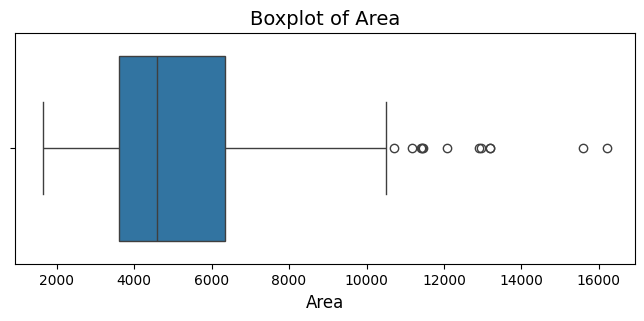

In [14]:
plt.figure(figsize=(8, 3))
sns.boxplot(x=df["area"])

plt.title("Boxplot of Area", fontsize=14)
plt.xlabel("Area", fontsize=12)
plt.show()

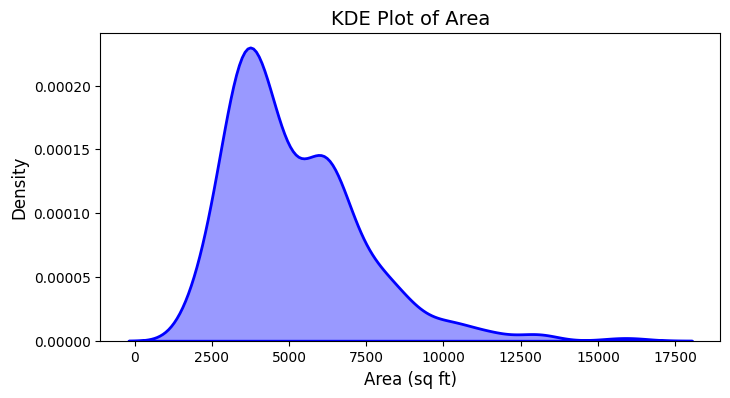

In [15]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df["area"], fill=True, color="blue", alpha=0.4, linewidth=2)

plt.title("KDE Plot of Area", fontsize=14)
plt.xlabel("Area (sq ft)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.show()

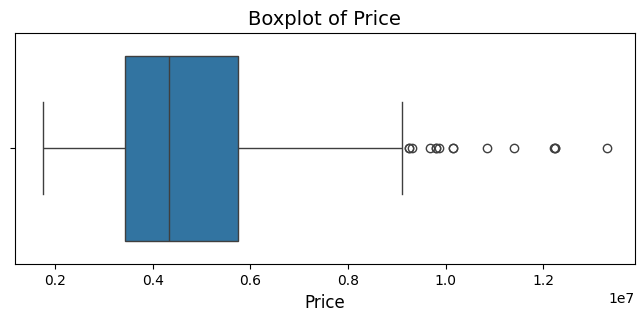

In [16]:
plt.figure(figsize=(8, 3))
sns.boxplot(x=df["price"])

plt.title("Boxplot of Price", fontsize=14)
plt.xlabel("Price", fontsize=12)
plt.show()

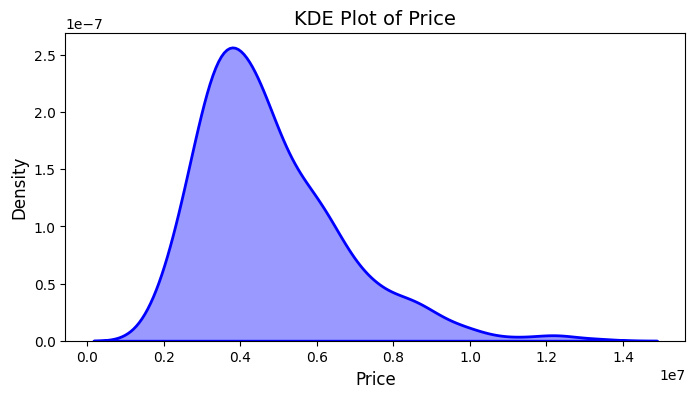

In [17]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df["price"], fill=True, color="blue", alpha=0.4, linewidth=2)

plt.title("KDE Plot of Price", fontsize=14)
plt.xlabel("Price", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.show()

**Analysis**
- When we look at the values of Area, the curve are not symmetric.
- They are skewed - meaning most values are clustered in a range, but a few extreme values (outliers) stretch the distribution toward one side.
  
**Why this is a problem for ML?**
- Many machine learning algorithms (like linear regression, logistic regression, KNN, neural networks) are sensitive to feature scaling.
- Outliers can distort scaling methods (like MinMaxScaler or StandardScaler) → making most data appear compressed into a small range.
- As a result, the model may give too much importance to these rare extreme values.

**Solution - using the clip function**
- clip() in pandas limits values to within a given range
- By clipping extreme values, You reduce skewness in the distribution.
- Scaling methods (like StandardScaler/MinMaxScaler) now work more effectively.
- The model becomes more robust and doesn’t overfit to rare outliers.

**References**
- https://www.simplypsychology.org/boxplots.html